In [5]:
#!pip install pyarrow

In [6]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
import math
import locale
#from common import MUNI_SECURITY_TYPE_DICT, COUPON_TYPE_DICT, COUPON_FREQUENCY_DICT, transform_to_datetime, diff_in_days, actual_diff_in_days, get_next_coupon_date, get_previous_coupon_date, get_time_delta_from_interest_frequency, get_ytw_and_price_data, transform_ytw_and_price_data
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
from time import sleep
from datetime import datetime,timedelta,date,time
from tqdm import tqdm, tqdm_notebook
from pandas import NaT
sns.set();

locale.setlocale( locale.LC_ALL, 'en_US' )

tqdm_notebook().pandas()

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

/Users/Gil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [7]:
import pandas as pd
from dateutil.relativedelta import relativedelta

MUNI_SECURITY_TYPE_DICT = {0:'Unknown',
                           1:'Special assessment',
                           2:'Double barreled',
                           3:'Lease-rental',
                           4:'Fuel/vehicle tax',
                           5:'Unlimited G.O.',
                           6:'Limited G.O.',
                           7:'Other',
                           8:'Revenue',
                           9:'Sales/excise tax',
                           10:'Tax allocation/increment',
                           11:'U.S. government-backed',
                           12:'Tobacco state appropriated',
                           13:'Tobacco settlement non-appropriated',
                           14:'Federal grant',
                           15:'Cigarette tax',
                           16:'Hotel tax',
                           17:'Miscellaneous tax',
                           18:'Personal income tax',
                           19:'Pilot'}


COUPON_TYPE_DICT = {0:'Unknown',
                    1:'Short term discount',
                    2:'Fixed rate - unconfirmed',
                    3:'Adjustable rate',
                    4:'Zero coupon',
                    5:'Floating rate',
                    6:'Index Linked',
                    7:'Stepped coupon',
                    8:'Fixed rate',
                    9:'Stripped convertible',
                    10:'Deferred interest',
                    11:'Floating rate @ floor',
                    12:'Stripped tax credit',
                    13:'Inverse floating',
                    14:'Stripped coupon principal',
                    15:'Linked inverse floater',
                    16:'Flexible rate',
                    17:'Original issue discount',
                    18:'Stripped principal',
                    19:'Reserve CUSIP',
                    20:'Variable rate',
                    21:'Stripped coupon',
                    22:'Floating auction rate',
                    23:'Tax credit',
                    24:'Tax credit OID',
                    25:'Stripped coupon payment',
                    26:'Stepped up stepped down',
                    27:'Credit Sensitive',
                    28:'Pay in kind',
                    29:'Range',
                    30:'Digital',
                    31:'Reset'}

COUPON_FREQUENCY_DICT = {0:None,
                         1:2,
                         2:12,
                         3:1,
                         4:52,
                         5:4,
                         6:0.5,
                         7:0.33333,
                         8:0.25,
                         9:0.2,
                         10:1/7,
                         11:1/8,
                         13:44,
                         14:360,
                         16:0,
                         23:None}


def transform_ytw_data(df):
    df['muni_security_type']= df['muni_security_type'].map(MUNI_SECURITY_TYPE_DICT)
    df['coupon_type']= df['coupon_type'].map(COUPON_TYPE_DICT) 
    df['interest_payment_frequency']= df['interest_payment_frequency'].map(COUPON_FREQUENCY_DICT)
    
    df['coupon_rate'] = df['coupon_rate'].astype(float)
    df['next_call_price'] = df['next_call_price'].astype(float)
    transform_to_datetime(df, ['settlement_date', 'first_coupon_date', 
                                'previous_coupon_payment_date', 'next_coupon_payment_date', 
                                'maturity_date', 'refund_date'])

def get_ytw_data(bqclient, trade_date):
    query = ''' SELECT
                IFNULL(settlement_date,
                assumed_settlement_date) AS settlement_date,
                trade_date,
                cusip,
                dated_date,
                dollar_price,
                issue_price,
                coupon AS coupon_rate,
                interest_payment_frequency,
                next_call_date,
                par_call_date,
                next_call_price,
                par_call_price,
                assumed_redemption_date,
                maturity_date AS maturity_date,
                previous_coupon_payment_date,
                next_coupon_payment_date,
                first_coupon_date,
                coupon_type,
                muni_security_type,
                called_redemption_type,
                refund_date,
                refund_price,
                is_callable,
                is_called,
                call_timing,
                yield
                FROM `eng-reactor-287421.primary_views.trade_history_with_reference_data`
                WHERE trade_date = \'''' + trade_date + '''\'
             '''
    
#       AND '2021-01-13' BETWEEN ice.ref_valid_from_date
#   AND ice.ref_valid_to_date
#   AND NOT ice.default_indicator
#   --AND ice.callable IS FALSE
#   --AND ice.next_call_date is not null
#   --AND msrb.yield > 0
#   AND msrb.maturity_date > DATE_ADD(IFNULL(msrb.settlement_date,
#       msrb.assumed_settlement_date),INTERVAL 6 month)
#   AND ice.next_call_date > DATE_ADD(IFNULL(msrb.settlement_date,
#       msrb.assumed_settlement_date),INTERVAL 6 month)
#   --AND (ice.next_call_date IS NOT NULL AND 
#   --  (ice.called_redemption_type IS NULL OR
#   --  ice.called_redemption_type NOT IN (1,2,3,4,5,6,13,14,15,17)))

    
    dataframe = bqclient.query(query).result().to_dataframe()
    return dataframe   

def diff_in_days(end_date,start_date, convention="360/30"):
    #See MSRB Rule 33-G for details
    Y2 = end_date.year
    Y1 = start_date.year
    M2 = end_date.month
    M1 = start_date.month
    D2 = end_date.day #(end_date - relativedelta(days=1)).day 
    D1 = start_date.day
    if convention == "360/30":
        D1 = min(D1, 30)
        if D1 == 30: D2 = min(D2,30)
        difference_in_days = (Y2 - Y1) * 360 + (M2 - M1) * 30 + (D2 - D1)
    else: 
        print("unknown convention", convention)
    return difference_in_days

def actual_diff_in_days(end_date,start_date):
    end_date = datetime(end_date.year, end_date.month, end_date.day)
    start_date = datetime(start_date.year, start_date.month, start_date.day)
    return (end_date - start_date).days #/daycount_convention

def get_next_coupon_date(first_coupon_date,start_date,time_delta):
    date = first_coupon_date
    while date < start_date:
        date = date + time_delta

    next_coupon_date = date
    return next_coupon_date

def get_previous_coupon_date(first_coupon_date,settlement_date,time_delta):
    date = first_coupon_date
    while date < settlement_date:
        date = date + time_delta

    prev_coupon_date = date - time_delta
    return prev_coupon_date


def transform_to_datetime(df, fields):
    for f in fields:
        df[f] = pd.to_datetime(df[f])
            

def get_time_delta_from_interest_frequency(interest_payment_frequency):
    #raise an error if interest_payment_frequency does not divide into 12: 
    if interest_payment_frequency != 0: 
        #delta = 12/interest_payment_frequency 
        if interest_payment_frequency <= 12:
            delta = 12/interest_payment_frequency
            time_delta = relativedelta(months=delta)
        elif interest_payment_frequency > 12 and interest_payment_frequency <= 52:
            delta = 52/interest_payment_frequency
            time_delta = relativedelta(weeks=delta)
    else: 
        time_delta = 0
    return(time_delta)

We only support Fixed rate, Original issue discount and Zero coupon, for now. Need to expand this.

In [8]:
bqclient = bigquery.Client()
muni_df = get_ytw_data(bqclient, '2021-07-08')

/Users/Gil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:136: PyarrowMissingWarning: Converting to a dataframe without pyarrow installed is often slower and will become unsupported in the future. Please install the pyarrow package.


In [9]:
transform_ytw_data(muni_df)

#print(muni_df["coupon_type"].value_counts().plot(kind = 'barh'))

len(muni_df)

29850

['Fixed rate' 'Original issue discount' 'Zero coupon' 'Deferred interest'
 'Stripped coupon principal']
AxesSubplot(0.125,0.125;0.775x0.755)


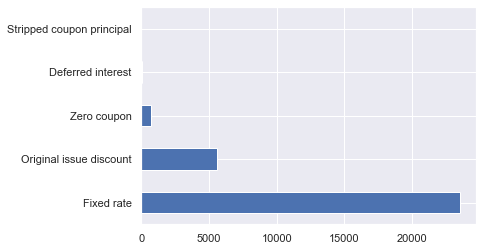

In [10]:
print(muni_df["coupon_type"].unique())
#print(muni_df["coupon_type"].value_counts())
print(muni_df["coupon_type"].value_counts().plot(kind = 'barh'))

#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Fixed rate', 'Original issue discount', 'Zero coupon',],axis=1)]    

get_yield function paramenters should be pruned to the ones needed

In [11]:
def get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date):
    
   #Y is the yield
    guess = 0.01
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);        
    P = dollar_price # the dollar price of the security for each $100 par value;
    R = coupon_rate # the annual interest rate expressed as a percentage, i.e., dollars per $100;
    RV = par # the redemption value of the security per $100 par value; and
    M = interest_payment_frequency 
    number_of_interest_payments = 0

    if R != 0 and interest_payment_frequency !=0: # Coupon paid every M periods
        last_date = next_coupon_date

        # count the coupon payment periods left: 
        while last_date <= end_date: # end_date: maturity_date or next_call_date
            number_of_interest_payments += 1
            last_date += time_delta

        final_coupon_date = last_date - time_delta

        if pd.isnull(prev_coupon_date): prev_coupon_date = dated_date

        N = number_of_interest_payments    
        D = diff_in_days(end_date,final_coupon_date,"360/30") #Time from final Payment to Redemption, can be Zero  
        A = diff_in_days(settlement_date,prev_coupon_date,"360/30") # accrued days from beginning of the interest payment period
        E = B/M # number of days in interest payment period 

        # formula to handle one coupon left paid at maturity (or call date)
        if end_date<=next_coupon_date:
            DTC = diff_in_days(end_date,prev_coupon_date) # accrual days for final paid coupon
            DA = diff_in_days(settlement_date,prev_coupon_date) # accrual days for coupon owed in dirty price
            DM = diff_in_days(end_date,settlement_date) # hold period days
            
            # formula is ((Redemption Value + Coupon Paid at Maturity)/Dirty Price - 1) * 
            # (100 *  Payments per Year)/(Hold Period scaled for payments per year)
            return round( (((RV+(R/M)*(DTC*M/B))/(P+(R/M)*(DA*M/B)))-1)*(M*100)/(DM*M/B),3)

        else:
            #print('P=%s\nRV=%s\nR=%s\nD=%s\nB=%s\nY=%s\nM=%s\nN=%s\nE=%s\nA=%s\nrange(N)==%s\n' %(P,RV,R,D,B,'_',M,N,E,A,range(N)))    
            ytm_func = lambda Y: (RV + R*D/B)/(1+Y/M)**(N-1 + (E-A)/E + D/E) + sum([(R/M)/(1+Y/M)**(K+(E-A)/E) for K in range(N)]) - (P + R*A/B)        
                
    elif R != 0 and interest_payment_frequency == 0:
        # Interest at maturity, Rule 33-G (b)(i)A(b) - why do we get them as negatives??
        A = diff_in_days(settlement_date,dated_date,"360/30")
        DIR = diff_in_days(end_date,dated_date,"360/30")
        ytm_func = lambda Y: ((RV + (DIR/B*R))/(1-((DIR-A)/B*Y)))-(P + R*A/B)
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)*-1 #fix this * -1. (check by pluggin in the positive)
    
    elif R == 0:
        # for Zero coupon use semi annual 360/30 convention
        periods = diff_in_days(end_date,settlement_date)/180.0
        ytm = ((par/P)**(1/periods)-1)*200
        return round(ytm,3)
    try:
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)
    except Exception as e:
        print(e)
        return None

In [12]:
def compute_yield(x):

    time_delta = get_time_delta_from_interest_frequency(x.interest_payment_frequency)
    my_prev_coupon_date,my_next_coupon_date = None, None
    # Explain: why is data missing? Why do we need to change an exisiting next_coupon_payment_date?   
    if x.coupon_rate != 0 and x.interest_payment_frequency != 0:
        my_next_coupon_date = pd.to_datetime(x.next_coupon_payment_date)
        my_prev_coupon_date = pd.to_datetime(x.previous_coupon_payment_date)

        if (pd.isnull(x.previous_coupon_payment_date)):
            my_prev_coupon_date = get_previous_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
        if  (pd.isnull(x.next_coupon_payment_date)):
            my_next_coupon_date = get_next_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
        #But why?: 
        if x.next_coupon_payment_date < x.settlement_date and pd.isnull(x.previous_coupon_payment_date):
            my_next_coupon_date = get_next_coupon_date(x.first_coupon_date,x.settlement_date,time_delta)
    
    if (not x.is_called) and (not x.is_callable):
        end_date = x.maturity_date
        par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,my_next_coupon_date,
                        end_date,x.settlement_date,x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        return ytm
    
    if x.is_called:
        if x.called_redemption_type == 1 or x.called_redemption_type == 5:
            end_date = x.maturity_date
        else:
            end_date = x.refund_date              
        if not pd.isnull(x.refund_price):
            par = x.refund_price
        elif not pd.isnull(x.next_call_price): 
            par = x.next_call_price
        else: 
            par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        return ytm
    
    else:
        
        ytf = float("inf")
        ytm = float("inf")
        yta = float("inf")
        ytp = float("inf")        
        
        if not pd.isnull(x.par_call_date):
            end_date = x.par_call_date
            par = x.par_call_price    
            ytp = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                            my_next_coupon_date,end_date,x.settlement_date,
                            x.dated_date,x.interest_payment_frequency,
                            x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)

        end_date = x.next_call_date #+ relativedelta(days=1)
        par = x.next_call_price    
        ytf = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        
        end_date = x.maturity_date
        par = 100
        ytm = get_yield(x.cusip,my_prev_coupon_date,x.first_coupon_date,
                        my_next_coupon_date,end_date,x.settlement_date,
                        x.dated_date,x.interest_payment_frequency,
                        x.dollar_price,x.coupon_rate,par,time_delta,x.maturity_date)
        
        # yield to anytime call below does not change anything, and we should rmeove this code after some testing: 
        yields = (ytf, ytm, yta,ytp)
    

        return(min(yields))


calculate the yield for each trade: 

In [13]:
muni_df['computed_ytw'] = muni_df.progress_apply(lambda x: compute_yield(x),axis=1)

  0%|          | 0/29850 [00:00<?, ?it/s]

### the below cells evaluate the results and top discrepancies:

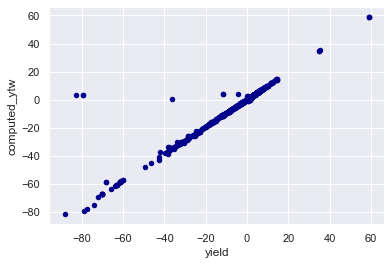

In [14]:
ax = muni_df.plot.scatter(x='yield',y='computed_ytw', c='DarkBlue')

In [15]:
muni_df['ytw_delta'] = muni_df['computed_ytw'] - muni_df['yield']

In [16]:
delta = muni_df.sort_values(by=['ytw_delta'])#,ascending=False)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30
delta = delta[delta.ytw_delta != 0]

In [17]:
delta

,settlement_date,trade_date,cusip,dated_date,dollar_price,issue_price,coupon_rate,interest_payment_frequency,next_call_date,par_call_date,next_call_price,par_call_price,assumed_redemption_date,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,called_redemption_type,refund_date,refund_price,is_callable,is_called,call_timing,yield,computed_ytw,ytw_delta
21284,2021-07-12,2021-07-08,358232K62,2011-10-13,59.293,31.209533,0.000,0.0,None,None,NaN,NaN,2021-08-01,2029-08-01,NaT,2029-08-01,2029-08-01,Zero coupon,Unlimited G.O.,17.0,2021-08-01,59.253414,False,True,NaN,0.608,-1.261,-1.869
21282,2021-07-12,2021-07-08,358232K62,2011-10-13,59.293,31.209533,0.000,0.0,None,None,NaN,NaN,2021-08-01,2029-08-01,NaT,2029-08-01,2029-08-01,Zero coupon,Unlimited G.O.,17.0,2021-08-01,59.253414,False,True,NaN,0.608,-1.261,-1.869
15732,2021-07-09,2021-07-08,358232N85,2011-10-13,41.038,20.969611,0.000,0.0,None,None,NaN,NaN,2021-08-01,2034-08-01,NaT,2034-08-01,2034-08-01,Zero coupon,Unlimited G.O.,17.0,2021-08-01,41.038124,False,True,NaN,1.473,0.005,-1.468
17807,2021-07-09,2021-07-08,358232N44,2011-10-13,55.020,28.706243,0.000,0.0,None,None,NaN,NaN,2021-08-01,2030-08-01,NaT,2030-08-01,2030-08-01,Zero coupon,Unlimited G.O.,17.0,2021-08-01,55.020001,False,True,NaN,1.423,0.000,-1.423
22894,2021-07-09,2021-07-08,358232N28,2011-10-13,63.646,33.810742,0.000,0.0,None,None,NaN,NaN,2021-08-01,2028-08-01,NaT,2028-08-01,2028-08-01,Zero coupon,Unlimited G.O.,17.0,2021-08-01,63.646246,False,True,NaN,1.389,0.006,-1.383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27802,2021-07-12,2021-07-08,77539VCW7,2007-04-18,101.111,98.429792,4.250,2.0,2021-08-08,2021-08-08,100.0,100.0,2024-08-01,2024-08-01,2021-02-01,2021-08-01,2007-08-01,Original issue discount,Tax allocation/increment,5.0,NaT,NaN,False,True,1.0,-11.413,3.860,15.273
27916,2021-07-12,2021-07-08,812643QT4,2011-02-08,100.355,104.721000,5.000,2.0,2021-08-08,2021-08-08,100.0,100.0,2021-08-08,2024-02-01,2021-02-01,2021-08-01,2011-08-01,Fixed rate,Revenue,NaN,NaT,NaN,True,False,1.0,-36.571,0.083,36.654
27718,2021-07-12,2021-07-08,478271FG9,1998-12-01,106.361,98.638000,5.125,2.0,2021-08-08,2021-08-08,100.0,100.0,2025-07-01,2025-07-01,2021-07-01,2022-01-01,1999-07-01,Original issue discount,Revenue,5.0,NaT,NaN,False,True,1.0,-79.649,3.398,83.047
27799,2021-07-12,2021-07-08,478271FG9,1998-12-01,106.361,98.638000,5.125,2.0,2021-08-08,2021-08-08,100.0,100.0,2025-07-01,2025-07-01,2021-07-01,2022-01-01,1999-07-01,Original issue discount,Revenue,5.0,NaT,NaN,False,True,1.0,-79.649,3.398,83.047


In [18]:
#how many did we get right: 
print(len(muni_df[muni_df['computed_ytw'] == muni_df['yield']])/len(muni_df))
print(len(muni_df[abs(muni_df['computed_ytw'] - muni_df['yield']) <= 0.001])/len(muni_df))

0.9615075376884422
0.9702847571189279
